In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [60]:
import webdataset as wds
import numpy as np
from itertools import islice
from collections import Counter
import glob
import os
import os.path

In [5]:
ds = wds.WebDataset("publaynet/publaynet-train-000000.tar").decode("rgb")

In [20]:
ids = []
for sample in islice(ds, 0, 200):
    for a in sample["json"]["annotations"]:
        ids.append(a["category_id"])
Counter(ids)

Counter({1: 1378, 4: 63, 2: 373, 3: 45, 5: 46})

In [37]:
sample = next(iter(ds))

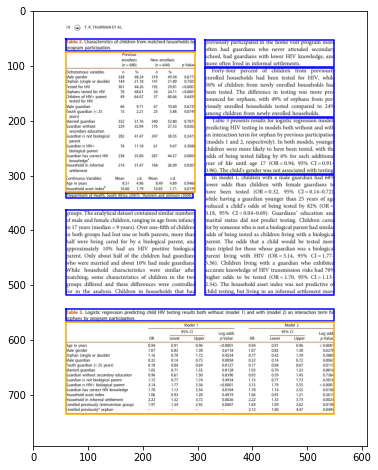

In [38]:
figsize(16, 8)
categories = ["black", "blue", "red", "green", "orange", "yellow", "cyan", "magenta"]
imshow(sample["png"])
for a in sample["json"]["annotations"]:
    x, y, w, h = a["bbox"]
    plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], color=categories[a["category_id"]])

In [52]:
def fill_rect(a, box, value, xpad=0, ypad=0, inc=False):
    h, w = a.shape[:2]
    x0, y0, x1, y1 = box
    if inc:
        a[max(y0-ypad, 0):min(y1+ypad, h), max(x0-xpad, 0):min(x1+xpad, w)] += value
    else:
        a[max(y0-ypad, 0):min(y1+ypad, h), max(x0-xpad, 0):min(x1+xpad, w)] = value

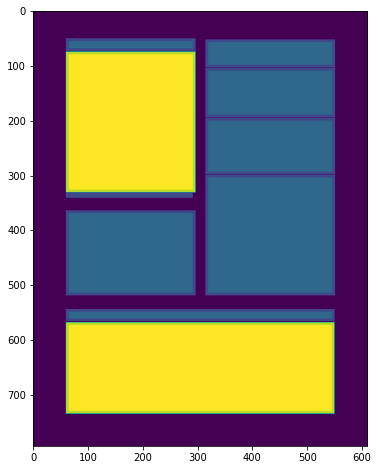

In [58]:
def make_target(sample, dx=5, dy=5):
    image = sample["png"]
    h, w = image.shape[:2]
    target = np.zeros((h, w), dtype=np.uint8)
    #overlap = np.zeros((h, w))
    for a in sample["json"]["annotations"]:
        x0, y0, w, h = [int(x+0.5) for x in a["bbox"]]
        x1, y1 = x0+w, y0+h
        box = (x0, y0, x1, y1)
        value = a["category_id"]
        #fill_rect(overlap, box, 1, inc=True, xpad=5, ypad=5)
        fill_rect(target, box, 2*value)
        if y1-y0 > dy and x1-x0 > dx:
            fill_rect(target, box, 2*value+1, xpad=-dx, ypad=-dy)
    return target
    
imshow(make_target(sample))

In [82]:
def make_targets(shard):
    output = "publaynet-seg/" + os.path.basename(shard) + "-rseg"
    print(shard, output)
    sink = wds.TarWriter(output)
    ds = wds.WebDataset(shard).decode("rgb")
    for sample in ds:
        target = make_target(sample)
        sample["target.png"] = target
        sink.write(sample)
    return output

In [83]:
shards = sorted(glob.glob("publaynet/publaynet-train-*.tar")) + sorted(glob.glob("publaynet/publaynet-val-*.tar"))

In [84]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=8, n_workers=1)
client

/home/tmb/.local/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37905 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41073 Dashboard: http://127.0.0.1:37905/status,Cluster Workers: 1 Cores: 8 Memory: 33.58 GB


In [85]:
from dask.delayed import delayed
make_targets = delayed(make_targets)

In [86]:
result = delayed([make_targets(shard) for shard in shards])

In [87]:
result.compute()

['laynet/publaynet-train-000000.tar',
 'laynet/publaynet-train-000001.tar',
 'laynet/publaynet-train-000002.tar',
 'laynet/publaynet-train-000003.tar',
 'laynet/publaynet-train-000004.tar',
 'laynet/publaynet-train-000005.tar',
 'laynet/publaynet-train-000006.tar',
 'laynet/publaynet-train-000007.tar',
 'laynet/publaynet-train-000008.tar',
 'laynet/publaynet-train-000009.tar',
 'laynet/publaynet-train-000010.tar',
 'laynet/publaynet-train-000011.tar',
 'laynet/publaynet-train-000012.tar',
 'laynet/publaynet-train-000013.tar',
 'laynet/publaynet-train-000014.tar',
 'laynet/publaynet-train-000015.tar',
 'laynet/publaynet-train-000016.tar',
 'laynet/publaynet-train-000017.tar',
 'laynet/publaynet-train-000018.tar',
 'laynet/publaynet-train-000019.tar',
 'laynet/publaynet-train-000020.tar',
 'laynet/publaynet-train-000021.tar',
 'laynet/publaynet-train-000022.tar',
 'laynet/publaynet-train-000023.tar',
 'laynet/publaynet-train-000024.tar',
 'laynet/publaynet-train-000025.tar',
 'laynet/pub